In [1]:
import os, sys
import scipy.io as sio
import glob
import numpy as np

import matplotlib.pyplot as plt
# %matplotlib inline
import pandas as pd
from scipy import stats
import researchpy as rp

# user defined module in .py
sys.path.append(os.path.join('..','connAnalyTool'))
from synchronization_index import ciCoherence 
# user defined module in .ipynb
import import_nbmodule
sys.path.append(os.path.join('..'))
from util.folder_extract import animal_folder

importing Jupyter notebook from ../util/folder_extract.ipynb


In [2]:
def allevent(filepatt):
    """ extract all the trials of event inf for one condition (i.e mild)"""
    files = glob.glob(filepatt)
    for i in range(len(files)):
        file = files[i]
        dat = sio.loadmat(file, variable_names = ['idxevent', 'fs'])
        if i == 0:
            idxevent = dat['idxevent']
            fs = dat['fs']
        else:
            idxevent = np.concatenate((idxevent, dat['idxevent']), axis = 0)
            
        tmp = dat['idxevent']
        t = np.squeeze((tmp[:,4] - tmp[:,0])/fs);
        if np.amax(t) > 3:
            print(file + " longest: " + str(np.amax(t)) + ", shortest: " + str(np.amin(t)))
    
    print(np.mean((idxevent[:,4] - idxevent[:,0])/fs))
    return idxevent, np.squeeze(fs)

In [3]:
animal = 'Pinky'
animalfolder, aniresfolder = animal_folder(animal = animal)
datfolder = os.path.join(animalfolder, 'epochs_reorg_filtered','betaBand')

# grob all mild or normal filtered files
filemild = os.path.join(datfolder , "*_mild_*.mat") # all the mild files
filenormal = os.path.join(datfolder , "*_normal_*.mat") # all the mild files
idxevent_mild, fs = allevent(filemild)
idxevent_normal, fs = allevent(filenormal)

/home/lingling/yang7003@umn.edu/NMRC_umn/Projects/FCAnalysis/data/Pinky/epochs_reorg_filtered/betaBand/Pinky_lfptrial_mild_092117_block3.mat longest: 3.0277632000000003, shortest: 0.9240576
1.2981502250569477
/home/lingling/yang7003@umn.edu/NMRC_umn/Projects/FCAnalysis/data/Pinky/epochs_reorg_filtered/betaBand/Pinky_lfptrial_normal_030217_block4.mat longest: 4.35683328, shortest: 1.09314048
1.353788747833002


In [4]:
def extrametrial_rm(idxevent):
    " idxevent is a matrix (n_trial * 5), trial duration time beyond 3 * std are treated as outlier"
    x = idxevent[:,4] - idxevent[:,0] # x: time length for each trial
    mean = np.mean(x)
    std = np.std(x)
    idxtrial = np.where((x >= mean-3*std) & (x <= mean + 3*std))[0]
    return idxevent[idxtrial, :]


def t_show(t1, t2, title = '', legend = ('normal','mild'), savefolder = ''):
    """
    image show the time length of t1 and t2 with statistical analysis 

    """ 

    fig = plt.figure()
    plt.plot(t1,'.g', label = legend[0])
    plt.plot(t2,'.r', label = legend[1])
    plt.title(title)
    plt.legend()

    ax = plt.gca()
    
    # check significance between two time lengths
    p = round(stats.ttest_ind(t1, t2)[1], 4)
    if p < 0.05:
        color = 'r'
        if p < 0.0001:
            s = 'p < 0.0001'
        else:
            s = "p = " + str(p)
    else:
        color = 'k'
        s = "p = " + str(p)
    plt.text(250, ax.get_ylim()[0] + 0.15, s , color = color) # plot the text of p value

    # plot the mean values 
    t1_mean = round(np.mean(t1),4)
    t2_mean = round(np.mean(t2),4)
    smean = "avg " + legend[0] + "= " + str(t1_mean) + ", " + legend[1] + "= " + str(t2_mean)
    plt.text(200, ax.get_ylim()[0]  + 0.1 , smean , color = 'k')
    
    # plot trial numbers
    n1 = t1.shape[0]
    n2 = t2.shape[0]
    strialn = "trialn " + legend[0] + "= " + str(n1) + ", " + legend[1] + "= " + str(n2)
    plt.text(200, ax.get_ylim()[0] + 0.05, strialn, color = 'k') # plot the text of p value
    
    plt.show()
    fig.savefig(os.path.join(savefolder,  title + '.png'))


class behaviorClass:
    """ behavior class """
    def __init__(self, animal, fs ,idxevent_normal, idxevent_mild, savefolder):
        
        self.idxevent_normal = extrametrial_rm(idxevent_normal)
        self.idxevent_mild = extrametrial_rm(idxevent_mild)
        self.savefolder = savefolder
        self.animal = animal
        self.fs = fs
        
        
    def tdur_calc(self, t_name  = "trial_length"):
        """calcualte the different time duration for t_name
        
            return:
                t_normal: n_trial * 1
                t_mild:  n_trial * 1
        """
        
        idxevent_mild = self.idxevent_mild
        idxevent_normal = self.idxevent_normal
        
        col_target, col_onset, col_touch, col_return, col_mouth = 0, 1, 2, 3, 4
        if t_name == "trial_length": 
            cols = [col_target] + [col_mouth]
        elif t_name == "target_onset":
            cols = [col_target] + [col_onset]
        elif t_name == "onset_touch": 
            cols = [col_onset] + [col_touch]
        elif t_name == "touch_return": 
            cols = [col_touch] + [col_return]
        elif t_name == "return_mouth":
            cols = [col_return] + [col_mouth]
        elif t_name == "onset_mouth": 
            cols = [col_onset] + [col_mouth]
            
        t_mild = np.squeeze((idxevent_mild[:,cols[1]] - idxevent_mild[:,cols[0]])/self.fs);
        t_normal = np.squeeze((idxevent_normal[:,cols[1]] - idxevent_normal[:,cols[0]])/self.fs);
        
        return t_normal, t_mild
    
    def tdur_expmeanstd(self, titles = ["trial_length", "target_onset", "onset_touch", "touch_return", "return_mouth", "onset_mouth"]):
        """
            export all mean and std values of different time intervals in titles
            
            
        """
        
        # generate the array arr of tnor_mean, tnor_std, tmild_mean, tmild_std
        ncols = len(titles)
        nrows = 4
        arr = np.zeros((nrows, ncols))
        for i, title in enumerate(titles):
            t_normal, t_mild = self.tdur_calc(title)
            
            tnor_mean = round(np.mean(t_normal),4)
            tnor_std = round(np.std(t_normal),4)

            tmild_mean = round(np.mean(t_mild),4)
            tmild_std = round(np.std(t_mild),4)
            arr[:, i] = [tnor_mean, tnor_std, tmild_mean, tmild_std]      
        
        with open(os.path.join(self.savefolder, "behav_meanstd.csv"), "w", newline='') as fp:
            wr = csv.writer(fp, dialect='excel')
            wr.writerow([" "] + titles)
            arrlist = []
            
            for rowi in range(nrows):
                if rowi == 0:
                    rowname = ['normal_mean']
                elif rowi == 1:
                    rowname = ['normal_std']
                elif rowi == 2:
                    rowname = ['mild_mean']
                elif rowi == 3:
                    rowname = ['mild_std']

                arrlist.append(rowname + arr[rowi,:].tolist()) 
                wr.writerow(arrlist[rowi])
        
        return arrlist        

In [111]:
animal = 'Pinky'
animalfolder, aniresfolder = animal_folder(animal = animal)
datfolder = os.path.join(animalfolder, 'epochs_reorg_filtered','betaBand')

# grob all mild or normal filtered files
filemild = os.path.join(datfolder , "*_mild_*.mat") # all the mild files
filenormal = os.path.join(datfolder , "*_normal_*.mat") # all the mild files
idxevent_mild, fs = allevent(filemild)
idxevent_normal, fs = allevent(filenormal)

behav = behaviorClass(animal, fs, idxevent_normal, idxevent_mild, os.path.join(aniresfolder, 'behavior'))

arrlist = behav.tdur_expmeanstd()

print(idxevent_mild)


[[ 254  279  462  542  732]
 [ 254  259  444  832 1024]
 [ 254  264  454  459  644]
 ...
 [ 254  289  399  437  569]
 [ 254  287  422  457  599]
 [ 254  287  404  444  582]]


In [7]:
def statis_show(titles = ["trial_length", "reaction time", "onset_touch", "touch_return", "return_mouth","onset_mouth"]):
    """ 
        statistical analysis of different time intervals of titles and images show them
    """ 
    
    animal = 'Pinky'
 
    animalfolder, aniresfolder = animal_folder(animal = animal)
    datfolder = os.path.join(animalfolder, 'epochs_reorg_filtered','betaBand')

    # grob all mild or normal filtered files
    filemild = os.path.join(datfolder , "*_mild_*.mat") # all the mild files
    filenormal = os.path.join(datfolder , "*_normal_*.mat") # all the mild files
    idxevent_mild, fs = allevent(filemild)
    idxevent_normal, fs = allevent(filenormal)
    
    behav = behaviorClass(animal, fs, idxevent_normal, idxevent_mild, os.path.join(aniresfolder, 'behavior'))
    
    for title in titles:
        t_normal, t_mild = behav.tdur_calc(title)
        t_show(t_normal, t_mild, title = animal + ' ' + title, savefolder = behav.savefolder)

/home/lingling/yang7003@umn.edu/NMRC_umn/Projects/FCAnalysis/data/Pinky/epochs_reorg_filtered/betaBand/Pinky_lfptrial_mild_092117_block3.mat longest: 3.0277632000000003, shortest: 0.9240576
1.2981502250569477
/home/lingling/yang7003@umn.edu/NMRC_umn/Projects/FCAnalysis/data/Pinky/epochs_reorg_filtered/betaBand/Pinky_lfptrial_normal_030217_block4.mat longest: 4.35683328, shortest: 1.09314048
1.353788747833002


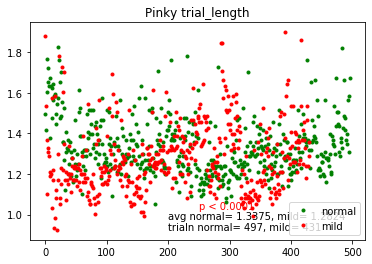

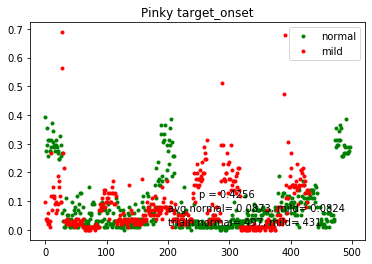

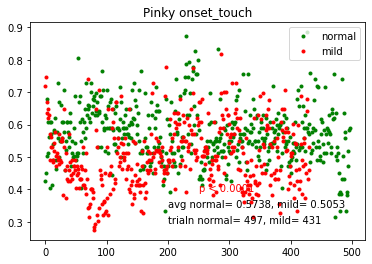

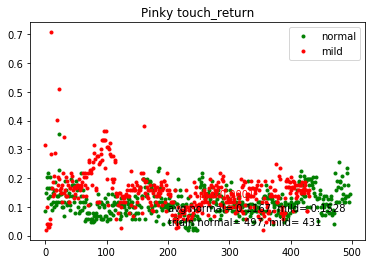

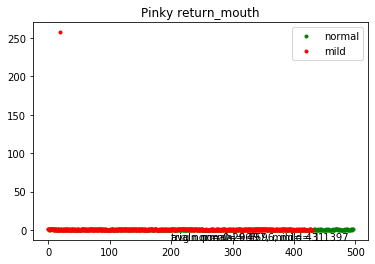

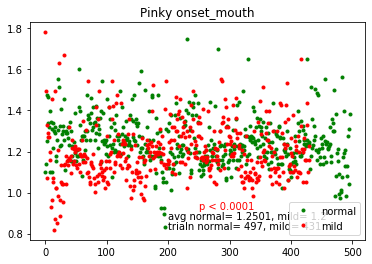

In [8]:
statis_show()


# if __name__ == '__main__':
#     statis_show()    